# SparkML with Dataproc Serverless

## Overview

This notebook tutorial demonstrates the execution of Apache SparkML jobs using Dataproc Serverless. This example machine learning pipeline ingests the [NYC TLC (Taxi and Limousine Commission) Trips](https://console.cloud.google.com/marketplace/product/city-of-new-york/nyc-tlc-trips) dataset from your lakehouse and performs cleaning, feature engineering, model training, and model evaluation to calculate trip duration.

The tutorial leverages the following Google Cloud products:
- `Dataproc`
- `BigQuery`
- `Vertex AI Training`
- `BigLake`

## Tutorial

### Set your project ID

In [1]:
# Retrieve the current active project and store it as a list of strings.
PROJECT_ID = !gcloud config get-value project

# Extract the project ID from the list.
PROJECT_ID = PROJECT_ID[0] if PROJECT_ID else None

### Get a Cloud Storage bucket URI

In [2]:
# Define the prefix of the bucket created via Terraform.
BUCKET_PREFIX = "gcp-lakehouse-raw"

# Retrieve the Cloud Storage bucket URI for storing the machine learning model.
BUCKET_URI = !gcloud storage buckets list --format='value(name)' --filter='name:{BUCKET_PREFIX}*'

# Extract the bucket URI from the list.
BUCKET_URI = BUCKET_URI[0] if BUCKET_URI else None

### Import required libraries

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from geopandas import gpd
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
# A Spark Session is how you interact with Spark SQL to create Dataframes
from pyspark.sql import SparkSession
# PySpark functions
from pyspark.sql.functions import col, floor, unix_timestamp

### Initialize the SparkSession

Use the [spark-bigquery-connector](https://github.com/GoogleCloudDataproc/spark-bigquery-connector) to read and write data between Apache Spark and BigQuery.

In [4]:
VER = "0.34.0"
FILE_NAME = f"spark-bigquery-with-dependencies_2.12-{VER}.jar"
connector = f"gs://spark-lib/bigquery/{FILE_NAME}"

# Set the log level to ERROR for the SparkSession to suppress the warning

# Initialize the SparkSession.
spark = (
    SparkSession.builder.appName("spark-ml-taxi")
    .config("spark.jars", connector)
    .config("spark.logConf", "false")
    .getOrCreate()
)

23/12/10 17:23:51 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


### Fetch data

Sample the data to reduce runtime. Increase the `FRACTION` to train on more data with the tradeoff of increasing the training time.

In [5]:
# Load NYC_taxi in Github Activity Public Dataset from BigQuery.
taxi_df = (
    spark.read.format("bigquery")
    .option(
        "table",
        f"{PROJECT_ID}.gcp_primary_staging.new_york_taxi_trips_tlc_yellow_trips_2022",
    )
    .load()
)

# Feel free to experiment with different values. The default value for the tutorial is set to 0.05. (5%)
FRACTION = 0.05

# Sample data to minimize the runtime.
taxi_df = taxi_df.sample(fraction=FRACTION, seed=42)

### Perform Exploratory Data Analysis (EDA)

Perform EDA to uncover more information about your data.

In [6]:
taxi_df.printSchema()

root
 |-- vendor_id: string (nullable = false)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: decimal(38,9) (nullable = true)
 |-- rate_code: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: decimal(38,9) (nullable = true)
 |-- extra: decimal(38,9) (nullable = true)
 |-- mta_tax: decimal(38,9) (nullable = true)
 |-- tip_amount: decimal(38,9) (nullable = true)
 |-- tolls_amount: decimal(38,9) (nullable = true)
 |-- imp_surcharge: decimal(38,9) (nullable = true)
 |-- airport_fee: decimal(38,9) (nullable = true)
 |-- total_amount: decimal(38,9) (nullable = true)
 |-- pickup_location_id: string (nullable = true)
 |-- dropoff_location_id: string (nullable = true)
 |-- data_file_year: long (nullable = true)
 |-- data_file_month: long (nullable = true)



Select only necessary columns and assess the null counts of the fields. Keep in mind that `pickup_location_id` and `dropoff_location_id` columns have been converted to strings but should be integers. To use these columns effectively, reformat these values.

23/12/10 17:24:00 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------------+--------------------+------------------+-----------------+------------------+----------------+-------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+
|summary|          start_time|            end_time|   passenger_count|    trip_distance|       fare_amount|           extra|            mta_tax|       tip_amount|      tolls_amount|     imp_surcharge|       airport_fee|     total_amount|     start_zone_id|       end_zone_id|
+-------+--------------------+--------------------+------------------+-----------------+------------------+----------------+-------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+
|  count|             1812865|             1812865|           1750675|          1812865|           1812865|         1812865|            1812865|          1812865|          

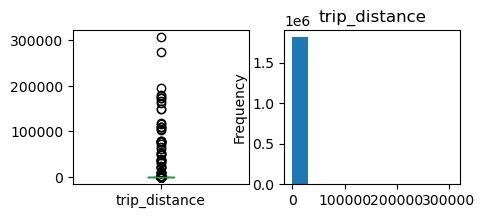

<Figure size 640x480 with 0 Axes>

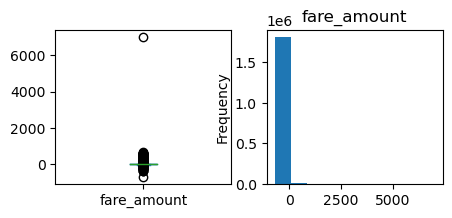

<Figure size 640x480 with 0 Axes>

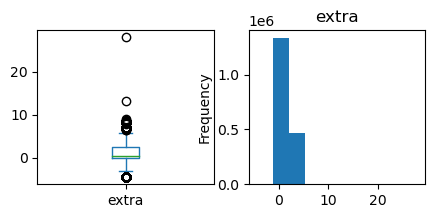

<Figure size 640x480 with 0 Axes>

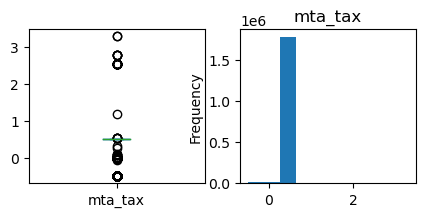

<Figure size 640x480 with 0 Axes>

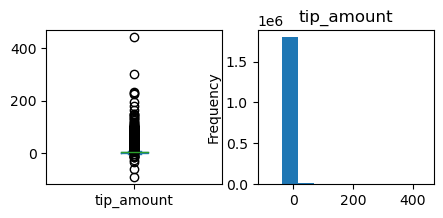

<Figure size 640x480 with 0 Axes>

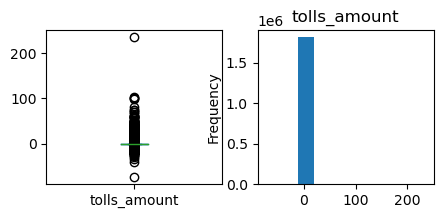

<Figure size 640x480 with 0 Axes>

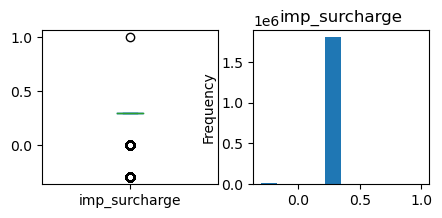

<Figure size 640x480 with 0 Axes>

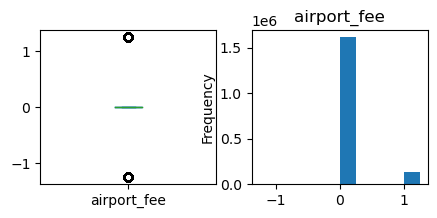

<Figure size 640x480 with 0 Axes>

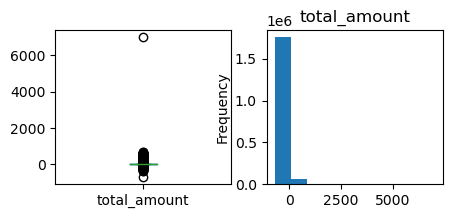

<Figure size 640x480 with 0 Axes>

In [7]:
# Choose necessary columns.
COLUMNS_TO_SELECT = [
    "start_time",
    "end_time",
    "passenger_count",
    "trip_distance",
    "fare_amount",
    "extra",
    "mta_tax",
    "tip_amount",
    "tolls_amount",
    "imp_surcharge",
    "airport_fee",
    "total_amount",
    "start_zone_id",
    "end_zone_id",
]

# Select the specified columns and convert pickup_location_id and dropoff_location_id to integers.
# Convert the datetime from string to Unix timestamp.
taxi_df = (
    taxi_df.withColumn("start_zone_id", col("pickup_location_id").cast("int"))
    .withColumn("end_zone_id", col("dropoff_location_id").cast("int"))
    .withColumn("start_time", unix_timestamp(col("pickup_datetime")))
    .withColumn("end_time", unix_timestamp(col("dropoff_datetime")))
    .select(*COLUMNS_TO_SELECT)
)


# Display summary statistics and preview the modified DataFrame.
taxi_df.describe().show()

# Convert Spark DataFrame into a Pandas DataFrame.
taxi_pd = taxi_df.toPandas()

# Define columns to be converted to numerical type in Pandas and be visualized.
PD_COLUMNS = [
    "trip_distance",
    "fare_amount",
    "extra",
    "mta_tax",
    "tip_amount",
    "tolls_amount",
    "imp_surcharge",
    "airport_fee",
    "total_amount",
]

# Convert columns of "object" type to the float type.
taxi_pd[PD_COLUMNS] = taxi_pd[PD_COLUMNS].astype(float)

# Disable the warning for too many open figures
plt.rcParams["figure.max_open_warning"] = 0

# Box plots and histograms for the specified columns.
for column in taxi_pd.columns:
    if column in PD_COLUMNS:
        _, ax = plt.subplots(1, 2, figsize=(5, 2))
        taxi_pd[column].plot(kind="box", ax=ax[0])
        taxi_pd[column].plot(kind="hist", ax=ax[1])
        plt.title(column)
        plt.figure()
plt.show()

From these summary and boxplots, several key insights emerge:
  * There are over 1 million trip histories for Yellow Taxi in 2022, which represents approximately 5% of the total trips.
  * Certain trip histories contain abnormalies, such as very large numbers in `trip_distance`.
  * The dataset's entries had included precise latitude and longitude data for both pickup and dropoff locations up until the year 2016. However, due to [privacy concerns](https://agkn.wordpress.com/2014/09/15/riding-with-the-stars-passenger-privacy-in-the-nyc-taxicab-dataset/), this granular location information was discontinued. Instead, the pickup_location_id and dropoff_location_id now align with the [NYC Taxi Zones](https://data.cityofnewyork.us/Transportation/NYC-Taxi-Zones/d3c5-ddgc), offering approximations based on the NYC Department of City Planning’s Neighborhood Tabulation Areas (NTAs) to indicate approximate neighborhood locations.

Based on the information above, the following filtering criteria can be used to remove unrealistic values from the dataset.
  * Exclude entries with excessively large `trip_distance` values, surpassing 10,000 miles.
  * Exclude entries with null and negative values.

In [8]:
taxi_df = taxi_df.where(
    (col("trip_distance") < 10000)
    & (col("fare_amount") > 0)
    & (col("extra") >= 0)
    & (col("mta_tax") >= 0)
    & (col("tip_amount") >= 0)
    & (col("tolls_amount") >= 0)
    & (col("imp_surcharge") >= 0)
    & (col("airport_fee") >= 0)
    & (col("total_amount") > 0)
).dropna()

Use the `unix_timestamp()` function to trasform `pickup_datetime` and `dropoff_datetime` into Unix Timestamp type.

Once you have converted `pickup_datetime` and `dropoff_datetime` to `start_time` and `end_time` as Unix Timestamps, you can manipulate these timestamps to generate more compelling columnnar data.

In [9]:
# Determine if it's a weekday.
taxi_df = taxi_df.withColumn(
    "is_weekday",
    ((floor(col("start_time") / 86400) + 4) % 7 > 0)
    & ((floor(col("start_time") / 86400) + 4) % 7 < 6),
)

# Convert start_time to start_time_in_hour.
taxi_df = taxi_df.withColumn(
    "start_time_in_hour", floor((col("start_time") % 86400) / 60 / 60)
)

# Calculate trip_duration.
taxi_df = taxi_df.withColumn("trip_duration", col("end_time") - col("start_time"))

# Drop unnecessary columns.
taxi_df = taxi_df.drop("pickup_datetime", "dropoff_datetime")

### Perform Feature Engineering

While the Taxi dataset contains trips for all NYC boroughs, the precise location information is categorized using `NYC Taxi zones`. Use the `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` public dataset to calculate longitude and latitude values.

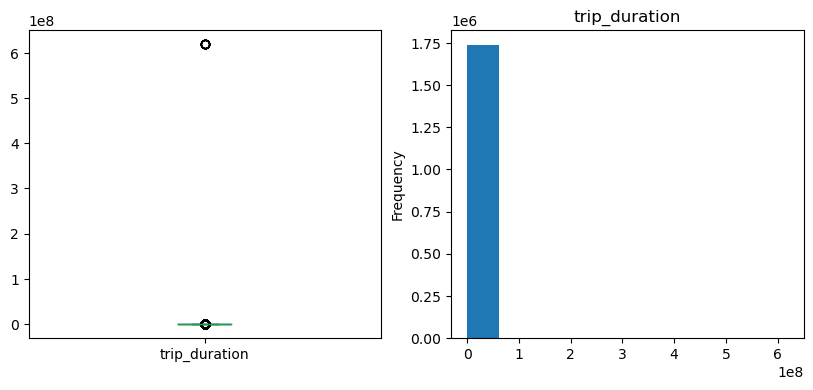

<Figure size 640x480 with 0 Axes>

In [10]:
# Load the GeoJSON format of NYC Taxi zones from the BigQuery public dataset.
geo_df = (
    spark.read.format("bigquery")
    .option("table", "bigquery-public-data.new_york_taxi_trips.taxi_zone_geom")
    .load()
)

# Convert Spark DataFrame into Pandas DataFrame to integrate with the GeoPandas library.
geo_pd = geo_df.toPandas()

# Create a GeoDataFrame based on the central point of each taxi zone, separated by latitude and longitude.
geo_pd["long"] = gpd.GeoSeries.from_wkt(geo_pd["zone_geom"]).centroid.x
geo_pd["lat"] = gpd.GeoSeries.from_wkt(geo_pd["zone_geom"]).centroid.y

# Drop unnecessary columns.
geo_pd = geo_pd[["zone_id", "long", "lat"]]

# Convert back to a Spark DataFrame.
geo_spark_df = spark.createDataFrame(geo_pd)

# Join taxi_df with geographic position for each start_zone_id.
taxi_zone_df = (
    taxi_df.join(geo_spark_df, taxi_df.start_zone_id == geo_spark_df.zone_id)
    .withColumnRenamed("long", "start_long")
    .withColumnRenamed("lat", "start_lat")
    .drop("zone_id")
    .join(geo_spark_df, taxi_df.end_zone_id == geo_spark_df.zone_id)
    .withColumnRenamed("long", "end_long")
    .withColumnRenamed("lat", "end_lat")
    .drop("zone_id")
)

# Convert Spark DataFrame into a Pandas DataFrame.
taxi_pd = taxi_df.toPandas()

# Convert columns of "object" type to the float type.
taxi_pd["trip_duration"] = taxi_pd["trip_duration"].astype(float)

# Box plots and histograms for the specified columns.
_, ax = plt.subplots(1, 2, figsize=(10, 4))
taxi_pd["trip_duration"].plot(kind="box", ax=ax[0])
taxi_pd["trip_duration"].plot(kind="hist", ax=ax[1])
plt.title("trip_duration")
plt.figure()
plt.show()

Same as `trip_distance`, `trip_duration` also has some extreme values. Remove unrealistic values from the dataset.

In [11]:
# Filter trips occurring between same taxi zones and exceeding where trip_duration is more than 28800 seconds (8 hours).
taxi_df = taxi_zone_df.where(
    (col("trip_duration") < 28800) & (col("start_zone_id") != col("end_zone_id"))
)

Organize the data into the scatterplot to see the relationship between `trip_distance` and `trip_duration`.

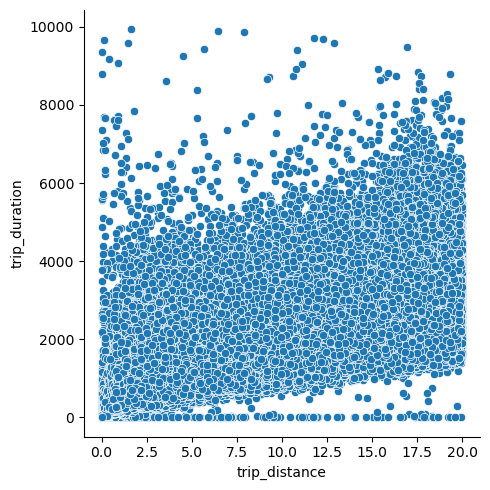

In [12]:
# Convert Spark DataFrame into a Pandas DataFrame.
taxi_pd = taxi_df.toPandas()

# Convert "trip_distance" column of "object" type to the float type.
taxi_pd["trip_distance"] = taxi_pd["trip_distance"].astype(float)

# Filter the DataFrame to include data within reasonable ranges.
taxi_pd_filtered = taxi_pd.query(
    "trip_distance > 0 and trip_distance < 20 \
    and trip_duration > 0 and trip_duration < 10000"
)

# Scatter plot to visualize the relationship between trip_distance and trip_duration.
sns.relplot(
    data=taxi_pd_filtered,
    x="trip_distance",
    y="trip_duration",
    kind="scatter",
)

The data is right-skewed, and a positive correlation is observed between `trip_distance` and `trip_duration`. 
The majority of trips are completed within an hour (3600 sec).

### Feature Selection

Not all features in our dataset will be utilized for training. After selecting the following columns as features, they must be assembled using `VectorAssembler()`, a feature transformer that consolidates multiple columns into a vector column.

In [13]:
# List of selected features for training the model.
feature_cols = [
    "passenger_count",
    "is_weekday",
    "start_time_in_hour",
    "trip_distance",
    "start_time",
    "end_time",
    "is_weekday",
    "start_time_in_hour",
    "start_long",
    "start_lat",
    "end_long",
    "end_lat",
    "total_amount",
    "fare_amount",
    "extra",
    "mta_tax",
    "tip_amount",
    "tolls_amount",
    "imp_surcharge",
    "airport_fee",
]

# Create a VectorAssembler with specified input and output columns.
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Transform each column into vector form using the VectorAssembler.
taxi_transformed_data = assembler.transform(taxi_df)

# Randomly split the transformed data into training and test sets.
(taxi_training_data, taxi_test_data) = taxi_transformed_data.randomSplit([0.95, 0.05])

### Training the Model

Use `GBTRegressor` model to train the data.

In [14]:
# Define GBTRegressor model with specified input, output, and prediction columns.
gbt = GBTRegressor(
    featuresCol="features",
    labelCol="trip_duration",
    predictionCol="pred_trip_duration",
)

# Define an evaluator for calculating the R2 score.
evaluator_r2 = RegressionEvaluator(
    labelCol=gbt.getLabelCol(), predictionCol=gbt.getPredictionCol(), metricName="r2"
)

# Define an evaluator for calculating the RMSE error.
evaluator_rmse = RegressionEvaluator(
    labelCol=gbt.getLabelCol(), predictionCol=gbt.getPredictionCol(), metricName="rmse"
)

In [15]:
# Train a Gradient Boosted Trees (GBT) model on the Taxi dataset. This process may take several minutes.
taxi_gbt_model = gbt.fit(taxi_training_data)

# Get predictions for the Taxi dataset using the trained GBT model.
taxi_gbt_predictions = taxi_gbt_model.transform(taxi_test_data)

In [16]:
# Evaluate the R2 score for the Taxi dataset predictions.
taxi_gbt_accuracy_r2 = evaluator_r2.evaluate(taxi_gbt_predictions)
print(f"Taxi Test GBT R2 Accuracy = {taxi_gbt_accuracy_r2}")

# Evaluate the Root Mean Squared Error (RMSE) for the Taxi dataset predictions.
taxi_gbt_accuracy_rmse = evaluator_rmse.evaluate(taxi_gbt_predictions)
print(f"Taxi Test GBT RMSE Accuracy = {taxi_gbt_accuracy_rmse}")

Taxi Test GBT R2 Accuracy = 0.8678348381985129


Taxi Test GBT RMSE Accuracy = 280.73886604396233


### View the result

Expect an R2 score of approximately 83-87% and a Root Mean Square Error(RMSE) of 200-300. This sample does not include [Cross-validation (statistics)](https://en.wikipedia.org/wiki/Cross-validation_%28statistics%29) which can provide improved model performance.

### Save the model to a Cloud Storage path

To ensure the preservation and accessibility of the trained model, it can be saved to a Cloud Storage path.

In [ ]:
# Save the trained model to a Cloud Storage path
taxi_gbt_model.write().overwrite().save(f"gs://{BUCKET_URI}/")